<a href="https://colab.research.google.com/github/rastringer/unraveling_superposition/blob/main/superposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction to Superposition



In [ ]:
!pip install torchviz torch transformers torchvision

Let's make a sinple neural network of two layers and a fully-connected layer.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # 784 input features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the model and move it to GPU
model = SimpleNet().to(device)

There are various ways of building a more intuitive understanding of the model we just made. The simplest is to print its architecture:

In [3]:
print(model)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


We can also use the `torchviz` library to create a helpful visualization:

In [4]:
from torchviz import make_dot

# Same size as input data
dummy_input = torch.randn(1, 28, 28).cuda()

graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))
graph.render("Model", format="png", cleanup=True)

'Model.png'

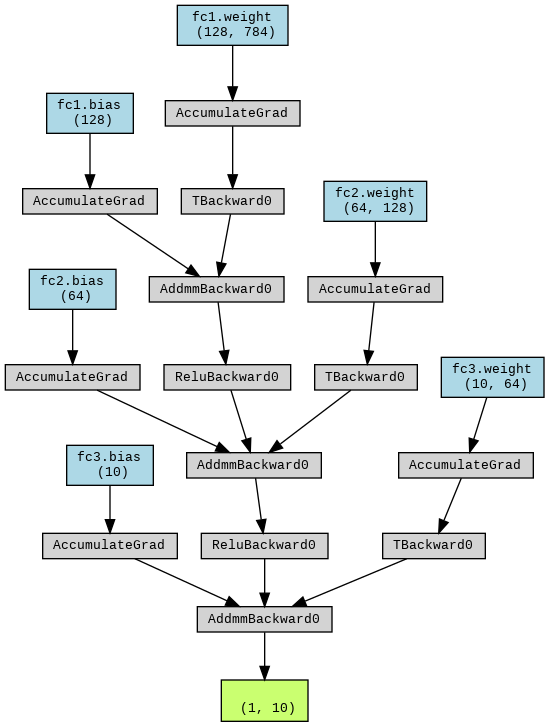

In [5]:
from IPython.display import Image, display

# Display the image in the notebook
image_path = "Model.png"
display(Image(filename=image_path))

To keep things simple and accessible on a Colab with free resources (the T4 GPU), we will use the canonical MNIST dataset of handwritten digits, 0-9.

Our training loop will run for five epochs and should complete within a few minutes on the T4.

In [9]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 5
for epoch in range(num_epochs):  # 5 epochs for demonstration
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.0020
Epoch [2/5], Loss: 0.0002
Epoch [3/5], Loss: 0.0047
Epoch [4/5], Loss: 0.0026
Epoch [5/5], Loss: 0.0004


### Visualizing Weight Matrices
One way to observe superposition is by visualizing the weight matrices of our layers. We can plot these as heatmaps:

In these heatmaps, look for:

* Patterns or structure in the weights
* Areas of high positive or negative values
* Regions where weights seem to cancel each other out

Generally, we see the first layer has sparse weights. This is because it connects directly to input pixels, many of which are not useful for making predictions, for example, the white space. The network will learn to assign very low weights to these less informative pixels.

In the second layer, we see a denser heatmap. Since this layer receives input from the first layer's activations, these features are likely to be meaningful and more evenly distributed for digit recognition. This leads to a denser weight matrix, since the layer is using more of its inputs.

### Relation to Superposition

Even the sparsity in the first layer may hide some degree of superposition, since the non-zero weights may be encoding multiple features in a superimposed manner. This is especially likely since the first layer ends up with fewer neurons than input dimensions. 

Reminding ourselves of the architecture:
```
(fc1): Linear(in_features=784, out_features=128, bias=True)
```
This means that the input features map to the 784 pixels of the MNIST images inputs, however its `out_features` reduces the dimensionality to 128.

In the second layer, where low-level features are combined into more abstract representations, superposition is noticeable as many patterns are encoded efficiently in a limited number of neurons.

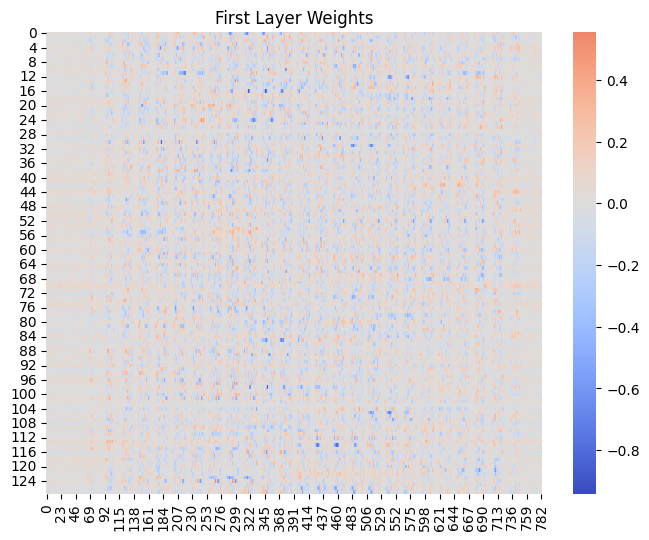

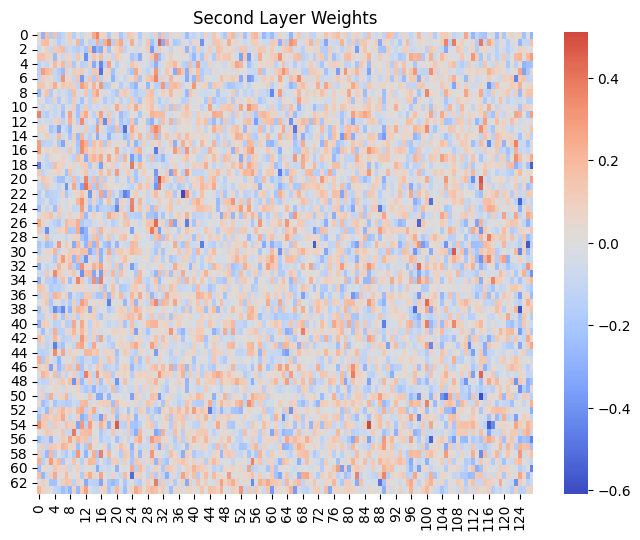

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_weight_matrix(weight_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weight_matrix.cpu().detach().numpy(), cmap='coolwarm', center=0)
    plt.title(title)
    plt.show()

plot_weight_matrix(model.fc1.weight, "First Layer Weights")
plot_weight_matrix(model.fc2.weight, "Second Layer Weights")

### Analyzing Activations
Another approach is to analyze the activations of neurons in response to different inputs:

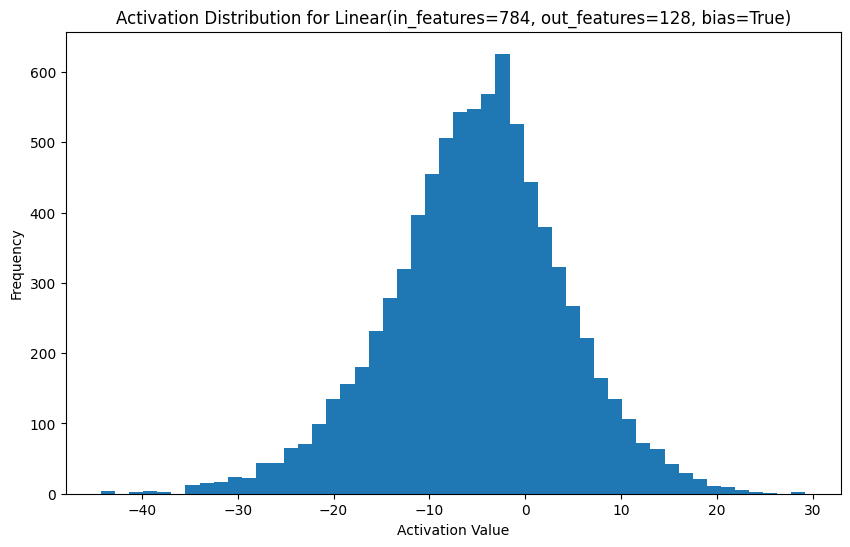

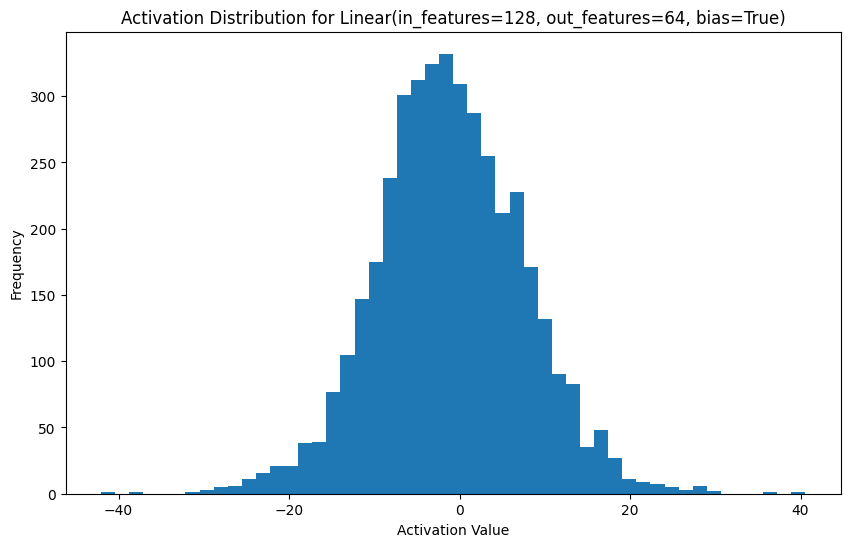

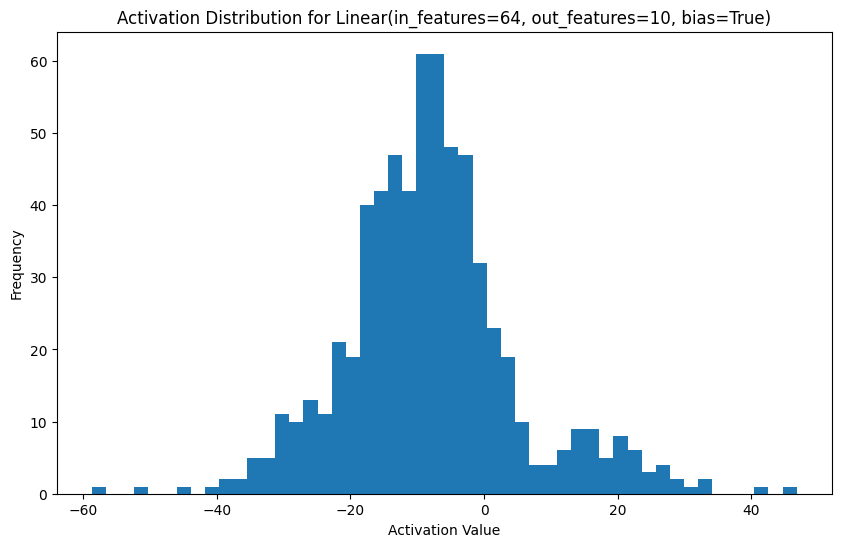

In [15]:
def get_activations(model, input_data):
    activations = {}

    def hook_fn(module, input, output):
        activations[module] = output.detach()

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            module.register_forward_hook(hook_fn)
    input_data = input_data.to(device)
    model(input_data)
    return activations

# Get a batch of test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, transform=transform),
    batch_size=64, shuffle=True)
test_data, _ = next(iter(test_loader))

activations = get_activations(model, test_data.view(test_data.size(0), -1))

# Plot activation distributions
for name, activation in activations.items():
    plt.figure(figsize=(10, 6))
    plt.hist(activation.cpu().numpy().flatten(), bins=50)
    plt.title(f"Activation Distribution for {name}")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.show()

### Measuring Superposition
To quantify superposition, we can use techniques like Singular Value Decomposition (SVD) on the weight matrices.

SVD is a technique in linear algebra to distill matrices into simpler component matrices.

In this example, we take the following steps (also commented in the code):

* Compute total variance, which is the sum of squared singular values
* Calculate the cumulative variance of each singular value

#### Interpretation

The 'effective rank' is a measure of superposition. A lower effective rank indicated less of the phenonemon. A higher effective rank suggests more, implying the weight matrix requires more dimensions to be accurately represented.

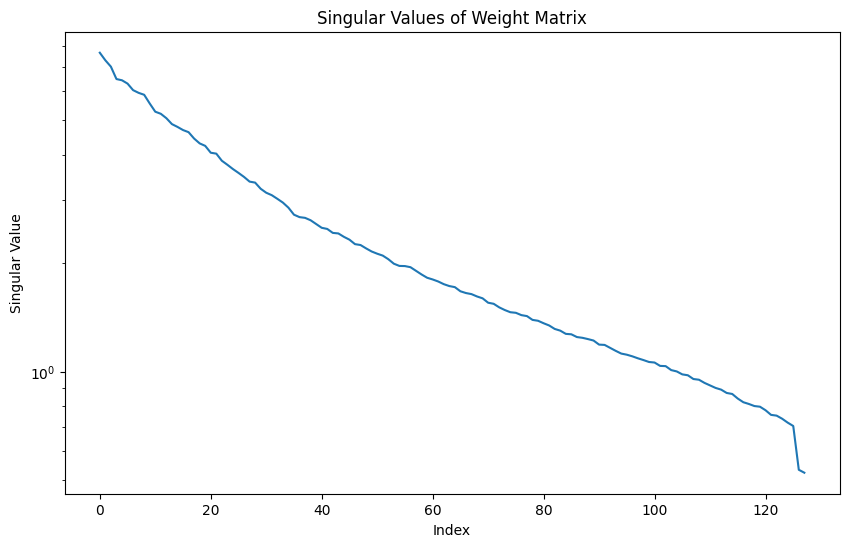

Effective Rank: 110


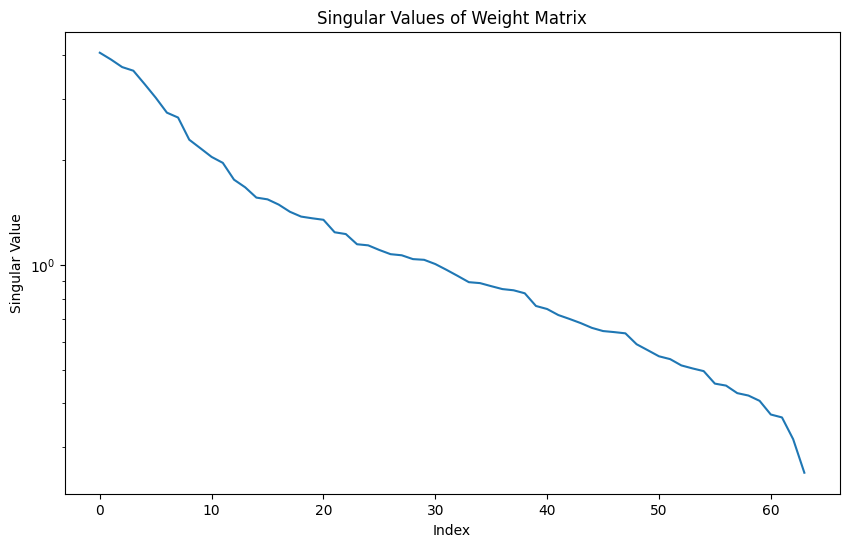

Effective Rank: 54


In [17]:
import numpy as np

def analyze_superposition(weight_matrix):
    # Here's the SVD calculation. The 'S' array contains the
    # singular values in descending order.
    U, S, Vt = np.linalg.svd(weight_matrix.cpu().detach().numpy())

    # Plot singular values
    plt.figure(figsize=(10, 6))
    plt.plot(S)
    plt.title("Singular Values of Weight Matrix")
    plt.xlabel("Index")
    plt.ylabel("Singular Value")
    plt.yscale('log')
    plt.show()

    # Calculate 'effective rank', which is a measure of superposition.
    # This computes the total variance (sum of squared values), then
    # calculates the cumulative variance explained by each singular value.
    total_variance = np.sum(S**2)
    cumulative_variance = np.cumsum(S**2) / total_variance
    effective_rank = np.sum(cumulative_variance < 0.99)  # 99% of variance

    print(f"Effective Rank: {effective_rank}")

analyze_superposition(model.fc1.weight)
analyze_superposition(model.fc2.weight)

In our SimpleNet model, we defined the following architecture:

```python

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
```

Let's compare the effective ranks we observed with the actual number of neurons in each layer:

First layer (fc1):

Total neurons: 128
Effective rank: 113
Ratio: 113 / 128 ≈ 0.883 or 88.3%


Second layer (fc2):

Total neurons: 64
Effective rank: 54
Ratio: 54 / 64 ≈ 0.844 or 84.4%



Interpretation:

First layer (fc1):
The effective rank of 113 compared to 128 total neurons suggests that this layer is using about 88.3% of its capacity for unique features, corresponding to a high degree of superposition. So a large number of singular values are needed to explain the variance in the weight matricies.

Second layer (fc2):
The effective rank of 54 vs 64 total neurons indicates that this layer is using about 84.4% of its capacity for unique features, showing a slight decrease that may indicate more specialization or feature abstraction in the second layer.

The effective rank gives us an idea of how many "effective features" the layer is representing. A higher effective rank compared to the actual number of neurons suggests neurons are representing multiple features simultaneously, indicating a higher degree of superposition.

### Interpreting the Results

When looking at the results, focus on sparse activation patterns, which might indicate specialized neurons.
Compare the number of neurons to the effective rank - a large discrepancy suggests a high degree of superposition.
Observe how superposition changes across layers.
Consider how different input patterns affect the activations and whether this reveals any superposed features.

### More layers, more data: CIFAR 100

Let's explore whether larger datasets and more complex neural network architectures affect the degree of superposition.

We switch to the ResNet50 model, which has 50 layers, including 48 convolutional layers, 1 max pool and 1 average pool layer. It uses skip connections to address the vanishing gradient problem, enabling training of deeper networks.

We will use the CIFAR-100 dataset, which comprises 60,000, 32 x 32 color images in 100 classes.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Load pre-trained ResNet50 model and modify for CIFAR-100
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 100)  # 100 classes in CIFAR-100
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Validation Accuracy: {100.*correct/total:.2f}%")

print("Training completed")



Using device: cuda


100%|██████████| 169001437/169001437 [00:04<00:00, 42237449.26it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

Epoch 1 loss: 3.3070


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.33it/s]


Validation Accuracy: 25.89%


Epoch 2/10: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 2 loss: 2.5782


Validation: 100%|██████████| 79/79 [00:03<00:00, 19.93it/s]


Validation Accuracy: 41.69%


Epoch 3/10: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s]


Epoch 3 loss: 2.1787


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.63it/s]


Validation Accuracy: 45.72%


Epoch 4/10: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 4 loss: 2.0079


Validation: 100%|██████████| 79/79 [00:03<00:00, 25.49it/s]


Validation Accuracy: 48.87%


Epoch 5/10: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]


Epoch 5 loss: 1.7884


Validation: 100%|██████████| 79/79 [00:05<00:00, 15.58it/s]


Validation Accuracy: 50.87%


Epoch 6/10: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 6 loss: 1.6728


Validation: 100%|██████████| 79/79 [00:03<00:00, 25.56it/s]


Validation Accuracy: 51.85%


Epoch 7/10: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 7 loss: 1.5569


Validation: 100%|██████████| 79/79 [00:03<00:00, 25.69it/s]


Validation Accuracy: 53.72%


Epoch 8/10: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]


Epoch 8 loss: 1.4626


Validation: 100%|██████████| 79/79 [00:04<00:00, 15.99it/s]


Validation Accuracy: 53.80%


Epoch 9/10: 100%|██████████| 391/391 [00:34<00:00, 11.32it/s]


Epoch 9 loss: 1.4110


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.77it/s]


Validation Accuracy: 54.18%


Epoch 10/10: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]


Epoch 10 loss: 1.3250


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.64it/s]

Validation Accuracy: 55.82%
Training completed


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

def get_activations(model, loader, num_batches=10):
    activations = OrderedDict()

    def hook_fn(name):
        def hook(module, input, output):
            activations[name] = output.cpu().detach()
        return hook

    # Register hooks for convolutional layers
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            module.register_forward_hook(hook_fn(name))

    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(loader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            _ = model(inputs)

    return activations

def analyze_superposition(activation, layer_name):
    reshaped = activation.reshape(activation.shape[1], -1).numpy()
    U, S, Vt = np.linalg.svd(reshaped, full_matrices=False)

    total_variance = np.sum(S**2)
    cumulative_variance = np.cumsum(S**2) / total_variance
    effective_rank = np.sum(cumulative_variance < 0.99)  # 99% of variance

    return {
        'layer_name': layer_name,
        'total_channels': activation.shape[1],
        'effective_rank': effective_rank,
        'ratio': effective_rank / activation.shape[1]
    }

# Get activations
activations = get_activations(model, test_loader)

# Analyze superposition for each layer
results = []
for name, activation in activations.items():
    results.append(analyze_superposition(activation, name))

# Create DataFrame
df = pd.DataFrame(results)

# Plot effective rank vs layer
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='effective_rank', marker='o')
plt.title('Effective Rank vs Layer')
plt.xlabel('Layer Index')
plt.ylabel('Effective Rank')
plt.xticks(df.index, df['layer_name'], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('effective_rank_vs_layer.png')
plt.close()

# Plot ratio of effective rank to total channels
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='ratio', marker='o')
plt.title('Ratio of Effective Rank to Total Channels vs Layer')
plt.xlabel('Layer Index')
plt.ylabel('Ratio')
plt.xticks(df.index, df['layer_name'], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('effective_rank_ratio_vs_layer.png')
plt.close()

print(df)
print("\nAnalysis completed. Check the generated PNG files for visualizations.")

               layer_name  total_channels  effective_rank     ratio
0                   conv1              64              59  0.921875
1          layer1.0.conv1              64              49  0.765625
2          layer1.0.conv2              64              53  0.828125
3          layer1.0.conv3             256             139  0.542969
4   layer1.0.downsample.0             256             133  0.519531
5          layer1.1.conv1              64              59  0.921875
6          layer1.1.conv2              64              58  0.906250
7          layer1.1.conv3             256             202  0.789062
8          layer1.2.conv1              64              60  0.937500
9          layer1.2.conv2              64              60  0.937500
10         layer1.2.conv3             256             231  0.902344
11         layer2.0.conv1             128             112  0.875000
12         layer2.0.conv2             128             113  0.882812
13         layer2.0.conv3             512       

### Interpretation

With some consistency, we see effective rank ratio decrease as the later network layers learn more abstract representations.

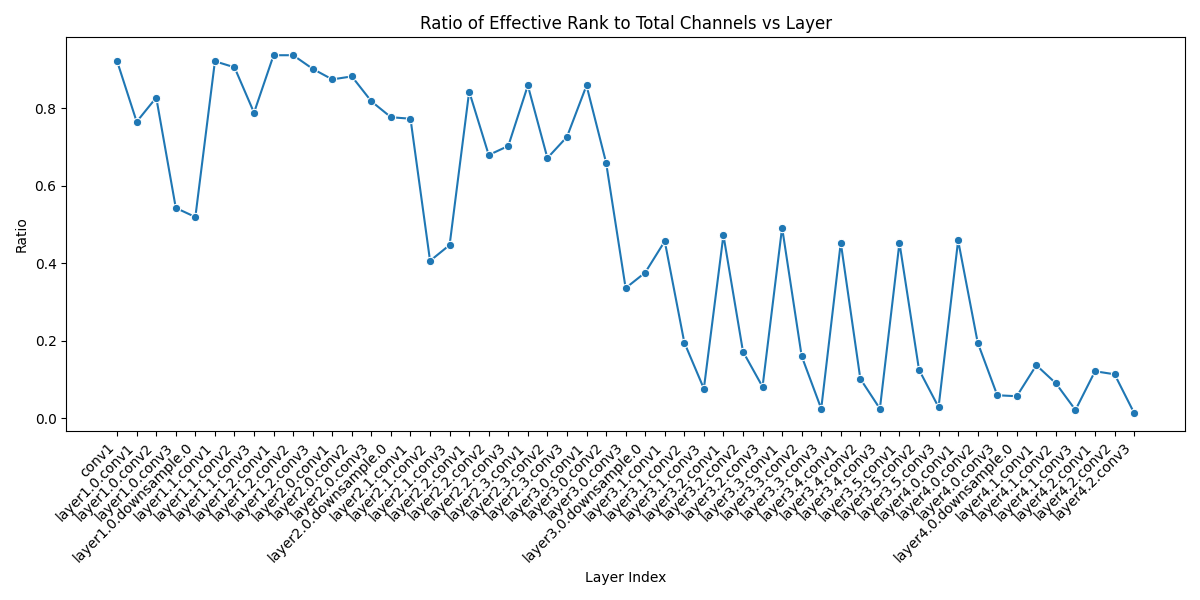

In [23]:
# Display the image in the notebook
image_path = "/content/effective_rank_ratio_vs_layer.png"
display(Image(filename=image_path))

# Interpreting Superposition Analysis Results

Let's analyze a result for one single convolutional layer

```
Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False):
Total channels: 512
Effective Rank: 67
Ratio: 0.13
```

1. Layer description: `Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)`
   - This is a 2D convolutional layer
   - It takes 2048 input channels and outputs 512 channels
   - It uses a 1x1 kernel size, which is essentially a pointwise convolution

2. Total channels: 512
   - In a convolutional neural network, each channel can be thought of as a "neuron" or a feature detector
   - So this layer has 512 "neurons" or feature detectors

3. Effective Rank: 67
   - This is significantly lower than the number of channels (512), indicating a small subset of the available dimensions are needed to explain most of the variance in the weight matrix. This suggests low superposition, since the majority of channels are not contributing  to complex representations.

4. Ratio: 0.13 (67 / 512)
   - This ratio indicates that only about 13% of the available dimensions are being effectively utilized

In summary, this result shows a lower degree of superposition, with the layer using only about 67 effective dimensions to represent information, despite having 512 channels available.